### Import libraries

In [1]:
# assignment 2B

Using same transformation methodologies (case normalization, number normalization, Punctuation,
stop word removal and lemmatization) on the hold out data set (as depicted in the week6 code)
obtain the F1 store for hold out data set. You can build something from scratch, or use classes
you have already built or use the code that I have provided in the week's code.

Bonus points if you improve your F1 score (on hold out) by doing some feature engineering through EDA
or by using more advanced vectorization.

Good luck






import nltk 
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
import re
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# pip install pycaret

### Read the Data

In [2]:
# Read the data
a=[]
b=[]
with open('/content/drive/MyDrive/Queens Collage/NLP Course 2022/SMSSpamCollection.txt','r') as f:
    l=f.readlines()
    for j in l:
        a.append(j.split('\t')[0])
        b.append(j.split('\t')[1])

In [3]:
# convert to pandas 
d={'label':a,'document':b}
df=pd.DataFrame(d)
df.head()

,label,document
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...\n
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# length of data
print(f"Entire corpus have {len(df)} documents")

Entire corpus have 5574 documents


In [ ]:
# Split training & hold out dats set
training_data = df.head(5000)
hold_out_data = df.tail(574)

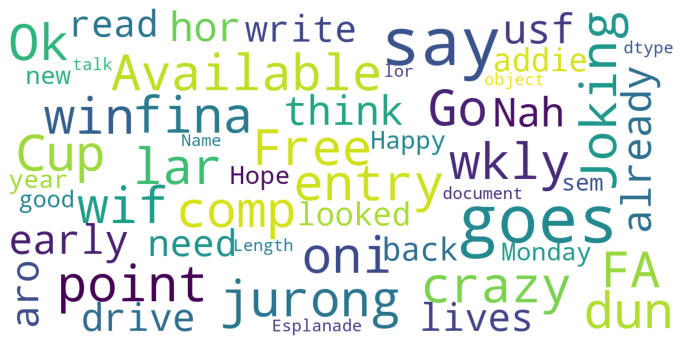

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        # stopwords=stopwords,
        max_words=7000,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(training_data['document'])
# show_wordcloud(Samsung_Reviews_positive['Reviews'])

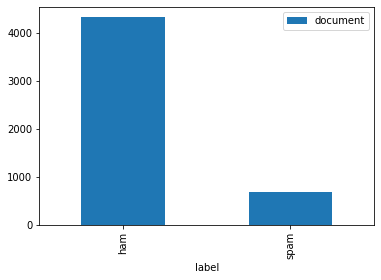

In [ ]:
from numpy.core.fromnumeric import size
from itertools import groupby
# data balance
(
    training_data
    .groupby(['label'])
    .count()
    .reset_index()
    .plot(kind='bar',x='label',y='document',)
)

### Text Processing Starts

In [ ]:
# get stop words
# from nltk.corpus import stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# lemmetizer
lem = WordNetLemmatizer()

In [ ]:
training_data.head()

,label,document
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...\n
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# lower case

training_data_clean = (
    # start with training data
    training_data
    # convert to lower case
    .assign(clean_document= lambda x:[text.lower() for text in x.document]) 
    # remove punctuation
    .assign(clean_document= lambda x: [re.sub("[^\w\s]","",text) for text in x.clean_document])
    # remove leading & trainling spaces 
    .assign(clean_document = lambda x: [text.strip() for text in x.clean_document])
    # remove all the '\n' values with space
    .assign(clean_document= lambda x: [re.sub(r"\n","",text) for text in x.clean_document] )
    # word tokenize
    .assign(word_token= lambda x: [nltk.word_tokenize(text) for text in x.clean_document] )
    # # remove stop words
    .assign(word_token= lambda x: [list(set(list_of_words).difference(stop_words)) for list_of_words in x.word_token])
    # Lemmatising the words
    .assign(word_token= lambda x: [[lem.lemmatize(a_word) for a_word in list_of_words] for list_of_words in x.word_token ])
    #  # input to sklearn
    # .assign(document_to_sklearn= lambda x: [" ".join(map(str,list_of_words)) for list_of_words in x.word_token ])
)

In [ ]:
training_data_clean

,label,document,clean_document,word_token
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[jurong, buffet, la, available, amore, wat, po..."
1,ham,Ok lar... Joking wif u oni...\n,ok lar joking wif u oni,"[u, wif, ok, oni, joking, lar]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,"[tkts, apply, free, may, final, wkly, txt, cup..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[early, c, already, dun, u, hor, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[dont, though, go, around, life, think, nah, usf]"
...,...,...,...,...
4995,ham,My drive can only be read. I need to write\n,my drive can only be read i need to write,"[read, need, write, drive]"
4996,ham,"Just looked it up and addie goes back Monday, ...",just looked it up and addie goes back monday s...,"[go, looked, suck, back, monday, addie]"
4997,ham,Happy new year. Hope you are having a good sem...,happy new year hope you are having a good seme...,"[happy, good, semester, new, hope, year]"
4998,ham,Esplanade lor. Where else...\n,esplanade lor where else,"[else, lor, esplanade]"


In [ ]:
training_data_clean

,label,document,clean_document,word_token,document_to_sklearn
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[la, buffet, cine, point, e, go, world, got, g...",la buffet cine point e go world got great n wa...
1,ham,Ok lar... Joking wif u oni...\n,ok lar joking wif u oni,"[joking, lar, u, ok, wif, oni]",joking lar u ok wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,"[receive, txt, questionstd, ratetcs, cup, tkts...",receive txt questionstd ratetcs cup tkts fa te...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[c, say, already, hor, u, dun, early]",c say already hor u dun early
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[dont, life, think, around, nah, go, usf, though]",dont life think around nah go usf though
...,...,...,...,...,...
4995,ham,My drive can only be read. I need to write\n,my drive can only be read i need to write,"[drive, need, read, write]",drive need read write
4996,ham,"Just looked it up and addie goes back Monday, ...",just looked it up and addie goes back monday s...,"[suck, looked, back, go, monday, addie]",suck looked back go monday addie
4997,ham,Happy new year. Hope you are having a good sem...,happy new year hope you are having a good seme...,"[hope, good, semester, year, happy, new]",hope good semester year happy new
4998,ham,Esplanade lor. Where else...\n,esplanade lor where else,"[esplanade, lor, else]",esplanade lor else


In [ ]:
# we can use chain and unpack method
import itertools
# get all the lists in one giant list
all_words = list(itertools.chain(*training_data_clean.word_token))
#get unique qords
vocabulary = list(set(all_words))

In [ ]:
# get frequency table
len(vocabulary)

7538

### Frequency Table

In [ ]:
from collections import Counter
word_counts = Counter(all_words)

In [ ]:
word_counts.most_common(5)

[('u', 788), ('call', 500), ('im', 388), ('get', 336), ('ur', 276)]

### Feature Extraction

In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 50)
X = vectorizer.fit_transform([i for i in training_data_clean['document_to_sklearn']])
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn['label'] = training_data_clean['label']
df_bow_sklearn

,back,call,cant,come,da,day,dont,free,get,go,going,good,got,hi,home,ill,im,know,later,like,lor,love,ltgt,make,mobile,need,new,night,ok,one,phone,please,reply,say,see,send,sorry,still,stop,take,tell,text,think,time,today,txt,ur,want,week,well,label
0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,spam
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,ham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
4996,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
4997,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham


### Modeling

In [ ]:
from pycaret.classification import *

In [ ]:
s = setup(data = df_bow_sklearn, target='label',
          numeric_features=vectorizer.get_feature_names(),
          session_id=123,verbose=False,silent=True)

In [ ]:
m = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4000,0.7311,0.9773,0.1706,0.2905,0.0973,0.2173
1,0.3914,0.6904,0.9318,0.1633,0.2780,0.0815,0.1807
2,0.4314,0.7319,0.9778,0.1818,0.3066,0.1147,0.2381
3,0.4171,0.7438,0.9778,0.1781,0.3014,0.1072,0.2293
4,0.4743,0.7519,0.9333,0.1883,0.3134,0.1265,0.2366
5,0.3971,0.7489,0.9556,0.1706,0.2896,0.0913,0.2015
6,0.4686,0.7416,0.9556,0.1894,0.3162,0.1293,0.2470
7,0.4000,0.7057,0.9556,0.1713,0.2905,0.0927,0.2033
8,0.4171,0.7474,1.0000,0.1807,0.3061,0.1129,0.2446
9,0.3582,0.6909,0.9545,0.1591,0.2727,0.0722,0.1753


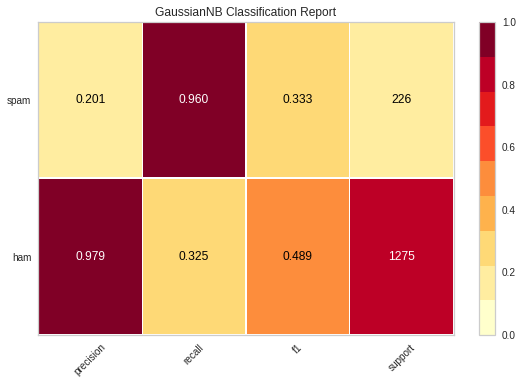

In [ ]:
plot_model(m,'class_report')

In [ ]:
com  = compare_models(sort='F1') 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9540,0.9444,0.7719,0.8587,0.8104,0.7844,0.7874,0.090
rf,Random Forest Classifier,0.9523,0.9395,0.7697,0.8460,0.8046,0.7775,0.7795,0.680
et,Extra Trees Classifier,0.9503,0.9338,0.7674,0.8337,0.7972,0.7690,0.7711,0.672
gbc,Gradient Boosting Classifier,0.9483,0.9377,0.7541,0.8296,0.7889,0.7595,0.7613,0.313
svm,SVM - Linear Kernel,0.9468,0.0000,0.7159,0.8489,0.7744,0.7446,0.7495,0.037
dt,Decision Tree Classifier,0.9437,0.9039,0.7494,0.8014,0.7727,0.7407,0.7423,0.038
lda,Linear Discriminant Analysis,0.9408,0.9294,0.7204,0.8029,0.7575,0.7240,0.7265,0.050
ada,Ada Boost Classifier,0.9423,0.9313,0.6916,0.8380,0.7501,0.7182,0.7268,0.203
lr,Logistic Regression,0.9408,0.9373,0.6826,0.8289,0.7455,0.7126,0.7186,0.041
knn,K Neighbors Classifier,0.9328,0.8901,0.6444,0.7953,0.7099,0.6725,0.6784,0.240


In [ ]:
com

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

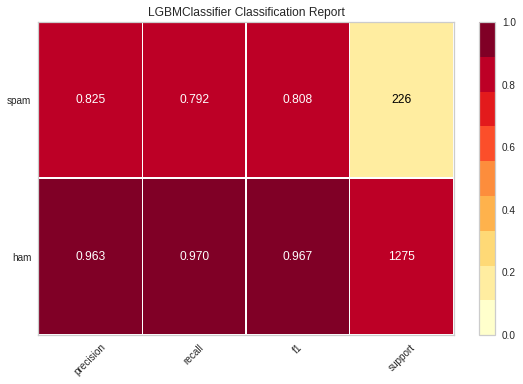

In [ ]:
plot_model(com,"class_report")

### Saving & Loading models

In [ ]:
com

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# save the top model from compare model
saved_model = save_model(com,"saved_model_pipeline")

Transformation Pipeline and Model Successfully Saved


In [ ]:
# load the saved model at late stage
loaded_model = load_model("saved_model_pipeline")

Transformation Pipeline and Model Successfully Loaded


In [ ]:
loaded_model

In [ ]:
# make a prediction
loaded_model.predict(df_bow_sklearn)

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
predict_model(com,data=)

### Bonus Code
#### How to use your class objects with pandas piping

In [43]:
# A class example
class NLP_preprocessor():
  """
  This does some NLP preprocessing
  """

  def __init__(self):
    return None

  def my_tokenizer(self,data_frame:pd.DataFrame,column_name:str)->list:
    """
    args:
        data_frame: pandas dataframe that containes all the documents
        column_name: column name that contains the documents. All documents
        should be string
    """
    tokens_array = [nltk.word_tokenize(text) for text in data_frame[column_name]]
    return tokens_array

  def my_lemmetizer(self,data_frame:pd.DataFrame,column_name:str)->list:
    """
    args:
        data_frame: pandas dataframe that containes all the documents
        column_name: column name that contains word tokens
    """ 
    # make sure that the column contains word tokens
    assert isinstance(data_frame[column_name][1],list), "Column must conain word tokens , i.e. lists of words" 
    # lemmetize 
    lem = WordNetLemmatizer()
    lemm_array = [[lem.lemmatize(a_word) for a_word in list_of_words] for list_of_words in data_frame[column_name]]
    return lemm_array
    

In [44]:
# initialize the class
nlp_p = NLP_preprocessor()

In [47]:
# How to  use pandas piping
(   # start with the data frame
    df
    # tokenize (with assign method)
    .assign(tokens=lambda x: nlp_p.my_tokenizer(x,'document'))
    # lemmetize
    .assign(lemmetize_tokens=lambda x: nlp_p.my_lemmetizer(x,'tokens')) 
)

,label,document,tokens,lemmetize_tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy.., Availab...","[Go, until, jurong, point, ,, crazy.., Availab..."
1,ham,Ok lar... Joking wif u oni...\n,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[U, dun, say, so, early, hor, ..., U, c, alrea..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[Nah, I, do, n't, think, he, go, to, usf, ,, h..."
...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,"[This, is, the, 2nd, time, we, have, tried, 2,...","[This, is, the, 2nd, time, we, have, tried, 2,..."
5570,ham,Will ü b going to esplanade fr home?\n,"[Will, ü, b, going, to, esplanade, fr, home, ?]","[Will, ü, b, going, to, esplanade, fr, home, ?]"
5571,ham,"Pity, * was in mood for that. So...any other s...","[Pity, ,, *, was, in, mood, for, that, ., So, ...","[Pity, ,, *, wa, in, mood, for, that, ., So, ...."
5572,ham,The guy did some bitching but I acted like i'd...,"[The, guy, did, some, bitching, but, I, acted,...","[The, guy, did, some, bitching, but, I, acted,..."
